## Problem statement:
Build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [ ]:
#import the required libraries
import pathlib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

from tensorflow.keras.preprocessing.image import load_img

In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#unzip the dataset
!unzip "/content/gdrive/MyDrive/CNN_assignment.zip" > /dev/null

In [ ]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [ ]:
# Count the number of image in Train and Test directory
# Using the glob to retrieve files/pathnames matching a specified pattern.

#Train Image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

#Test Image count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


**Data Visualization**

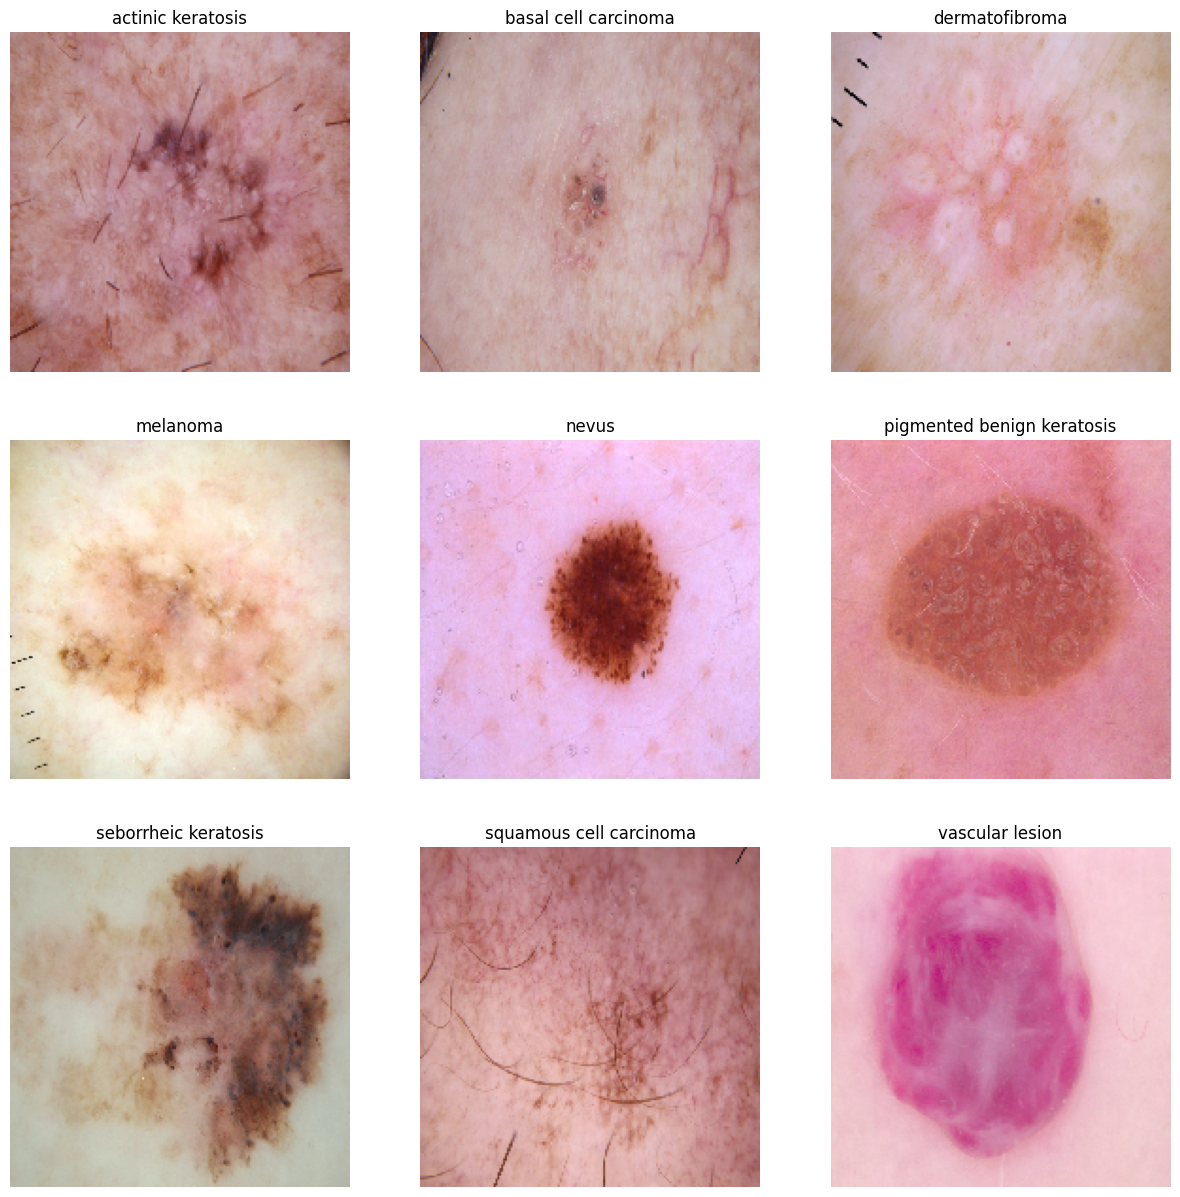

In [ ]:
#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

#Visualize image
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

**Visualize distribution of classes in the training dataset.**

In [ ]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,vascular lesion,139
1,melanoma,438
2,dermatofibroma,95
3,seborrheic keratosis,77
4,basal cell carcinoma,376
5,squamous cell carcinoma,181
6,nevus,357
7,actinic keratosis,114
8,pigmented benign keratosis,462


<Axes: xlabel='No. of Image', ylabel='Class'>

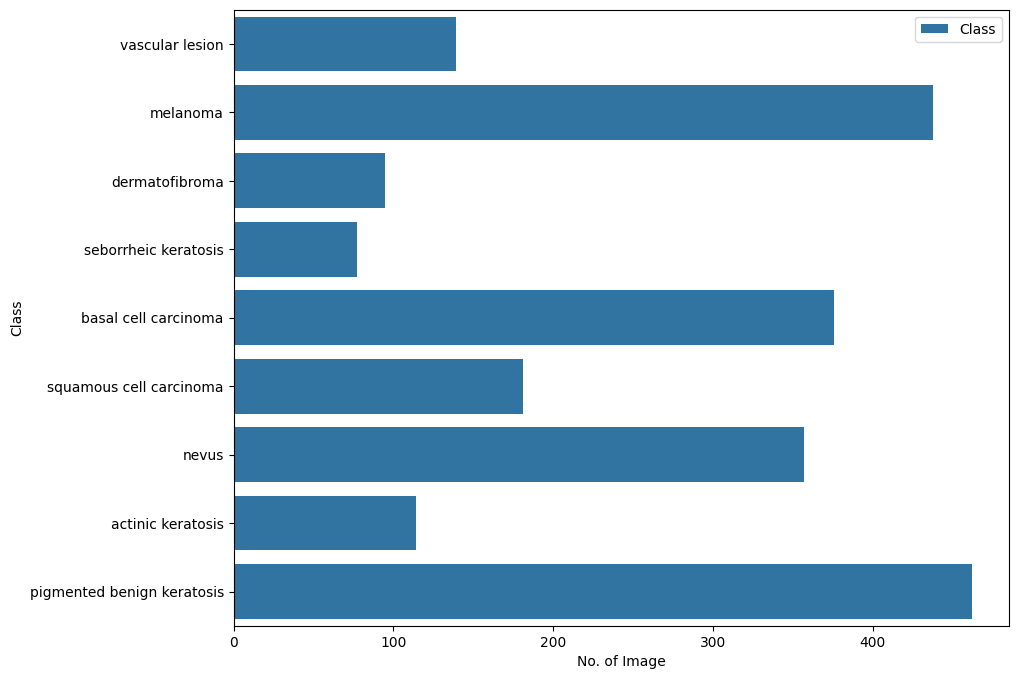

In [ ]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

There is a class imbalance to solve this using a python package  Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
#install Augmentor
!pip install Augmentor

In [ ]:
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7AC321911610>: 100%|██████████| 500/500 [00:15<00:00, 31.36 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AC36830A750>: 100%|██████████| 500/500 [00:17<00:00, 28.11 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AC350110C10>: 100%|██████████| 500/500 [00:19<00:00, 25.34 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7AC36836D110>: 100%|██████████| 500/500 [01:32<00:00,  5.42 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7AC356971790>: 100%|██████████| 500/500 [01:16<00:00,  6.56 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AC356972B10>: 100%|██████████| 500/500 [00:15<00:00, 32.59 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7AC350115C10>: 100%|██████████| 500/500 [00:37<00:00, 13.36 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AC35011BC90>: 100%|██████████| 500/500 [00:15<00:00, 31.76 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7AC350119790>: 100%|██████████| 500/500 [00:15<00:00, 32.89 Samples/s]


In [ ]:
#Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


**Model Building**

In [ ]:
# train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [ ]:
# validation dataset
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [ ]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.

#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.


AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer
model = Sequential()

# Rescaling Layer - Updated to use tf.keras.layers.Rescaling directly
model.add(layers.Rescaling(1./255, input_shape=(180,180,3)))

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

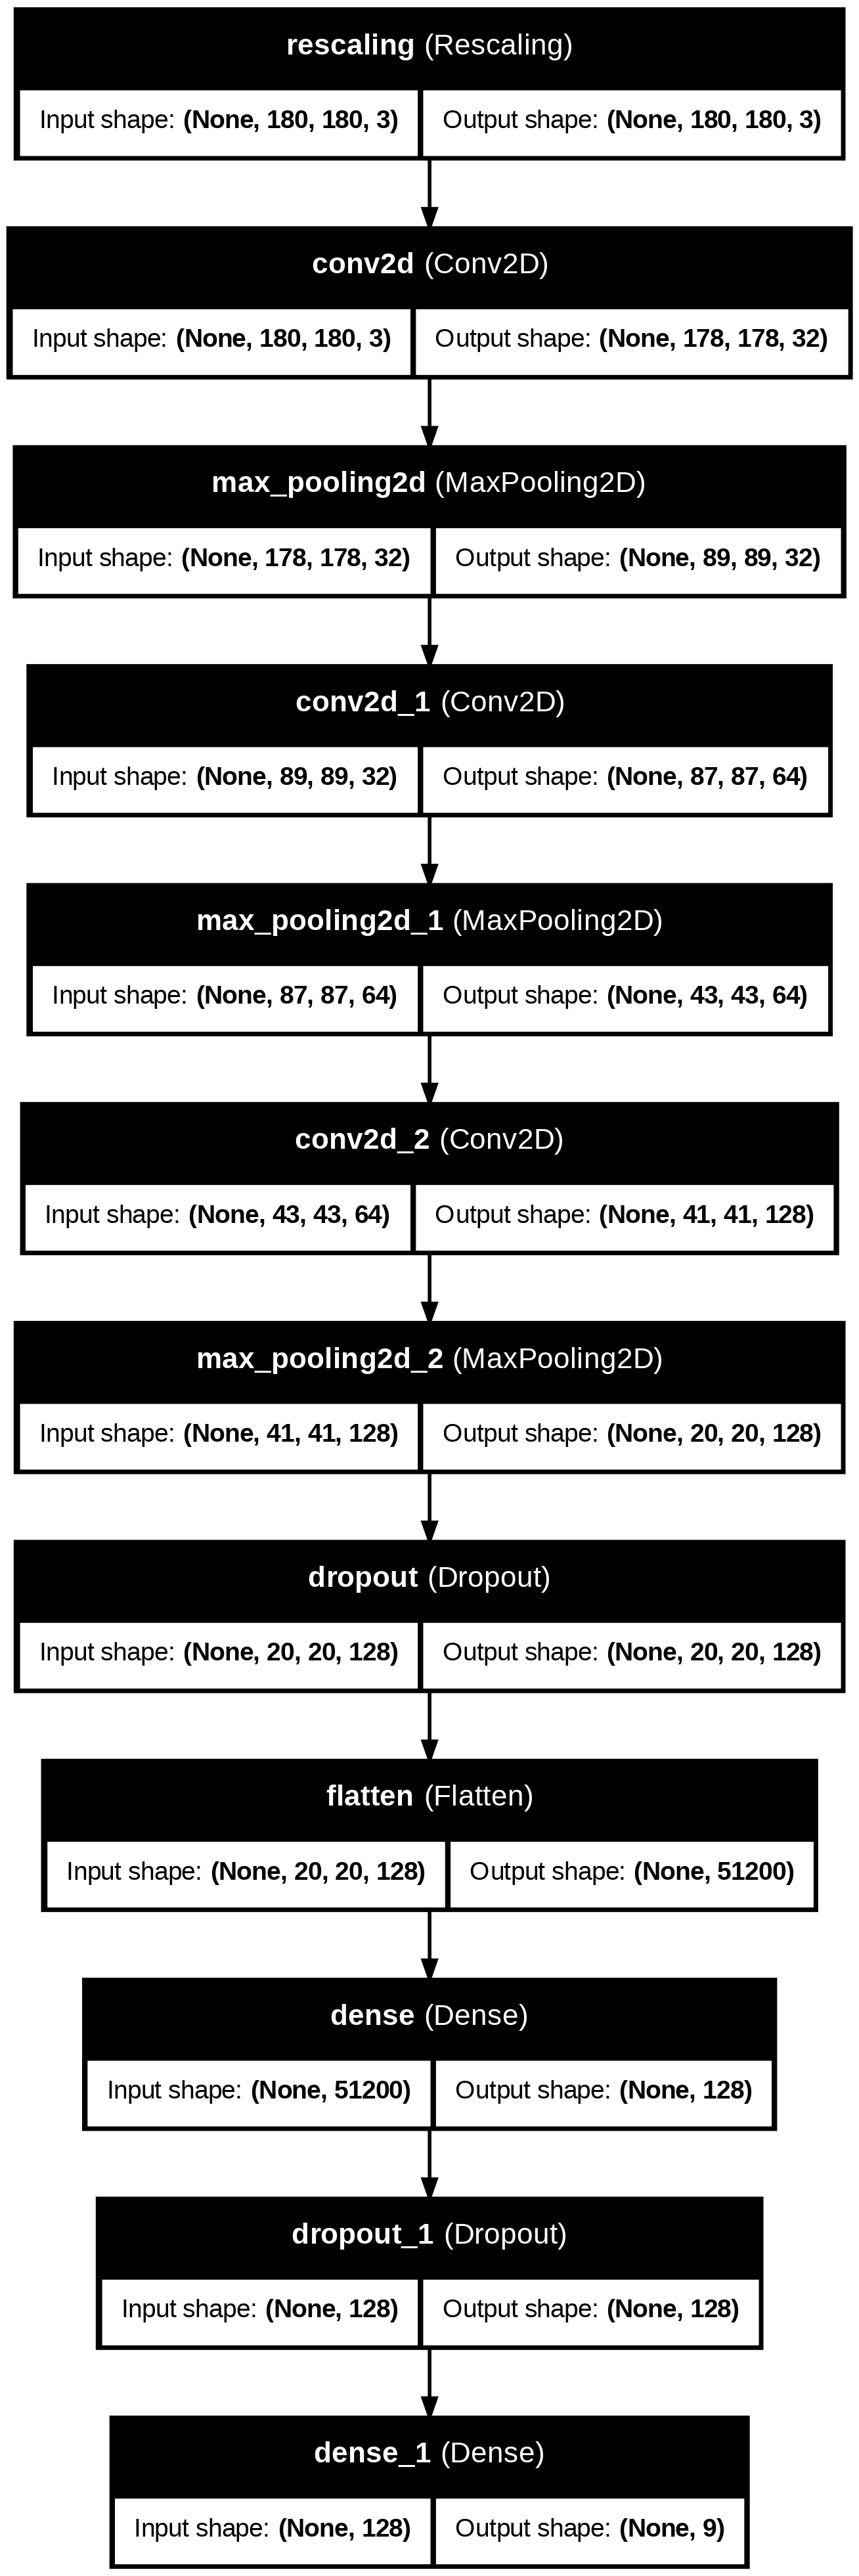

In [ ]:
# vizualizing the model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
#Compile the Model

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

In [ ]:
# Train the model

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[checkpoint,earlystop]
)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.2002 - loss: 2.2097
Epoch 1: val_accuracy improved from -inf to 0.41128, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 48s 114ms/step - accuracy: 0.2006 - loss: 2.2080 - val_accuracy: 0.4113 - val_loss: 1.5813
Epoch 2/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4121 - loss: 1.5859
Epoch 2: val_accuracy improved from 0.41128 to 0.48107, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 33ms/step - accuracy: 0.4124 - loss: 1.5851 - val_accuracy: 0.4811 - val_loss: 1.4010
Epoch 3/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4815 - loss: 1.3780
Epoch 3: val_accuracy improved from 0.48107 to 0.50854, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.4816 - loss: 1.3778 - val_accuracy: 0.5085 - val_loss: 1.2827
Epoch 4/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5160 - loss: 1.2883
Epoch 4: val_accuracy improved from 0.50854 to 0.57461, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.5162 - loss: 1.2880 - val_accuracy: 0.5746 - val_loss: 1.1128
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5684 - loss: 1.1545
Epoch 5: val_accuracy improved from 0.57461 to 0.60876, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.5685 - loss: 1.1544 - val_accuracy: 0.6088 - val_loss: 1.0597
Epoch 6/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6051 - loss: 1.0640
Epoch 6: val_accuracy did not improve from 0.60876
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.6050 - loss: 1.0639 - val_accuracy: 0.6006 - val_loss: 1.0779
Epoch 7/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6349 - loss: 0.9699
Epoch 7: val_accuracy improved from 0.60876 to 0.64811, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.6351 - loss: 0.9697 - val_accuracy: 0.6481 - val_loss: 0.9676
Epoch 8/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6692 - loss: 0.8879
Epoch 8: val_accuracy improved from 0.64811 to 0.70676, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.6692 - loss: 0.8879 - val_accuracy: 0.7068 - val_loss: 0.8369
Epoch 9/20
167/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6990 - loss: 0.8260
Epoch 9: val_accuracy did not improve from 0.70676
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.6991 - loss: 0.8258 - val_accuracy: 0.6993 - val_loss: 0.8303
Epoch 10/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7279 - loss: 0.7386
Epoch 10: val_accuracy improved from 0.70676 to 0.71938, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.7279 - loss: 0.7387 - val_accuracy: 0.7194 - val_loss: 0.7787
Epoch 11/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7537 - loss: 0.6738
Epoch 11: val_accuracy improved from 0.71938 to 0.73645, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.7536 - loss: 0.6739 - val_accuracy: 0.7365 - val_loss: 0.7823
Epoch 12/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7568 - loss: 0.6568
Epoch 12: val_accuracy improved from 0.73645 to 0.78396, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.7569 - loss: 0.6565 - val_accuracy: 0.7840 - val_loss: 0.6844
Epoch 13/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7921 - loss: 0.5569
Epoch 13: val_accuracy did not improve from 0.78396
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.7920 - loss: 0.5573 - val_accuracy: 0.7773 - val_loss: 0.6911
Epoch 14/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8023 - loss: 0.5274
Epoch 14: val_accuracy improved from 0.78396 to 0.80772, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.8023 - loss: 0.5274 - val_accuracy: 0.8077 - val_loss: 0.6163
Epoch 15/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8242 - loss: 0.4671
Epoch 15: val_accuracy improved from 0.80772 to 0.80846, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.8241 - loss: 0.4673 - val_accuracy: 0.8085 - val_loss: 0.6234
Epoch 16/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8297 - loss: 0.4550
Epoch 16: val_accuracy improved from 0.80846 to 0.81811, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.8295 - loss: 0.4552 - val_accuracy: 0.8181 - val_loss: 0.6244
Epoch 17/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8316 - loss: 0.4550
Epoch 17: val_accuracy did not improve from 0.81811
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.8316 - loss: 0.4549 - val_accuracy: 0.8085 - val_loss: 0.5765
Epoch 18/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8465 - loss: 0.4008
Epoch 18: val_accuracy did not improve from 0.81811
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8464 - loss: 0.4011 - val_accuracy: 0.7884 - val_loss: 0.6575
Epoch 19/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8529 - loss: 0.4010
Epoch 19: val_accuracy did not improve from 0.81811
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8528 - loss: 0.4013 - val_accuracy: 0.8092 - val_loss: 0.6622
Epoch 20/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8350 - loss: 0.4547
Epoch 20: val_accu

169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.8350 - loss: 0.4544 - val_accuracy: 0.8196 - val_loss: 0.6051


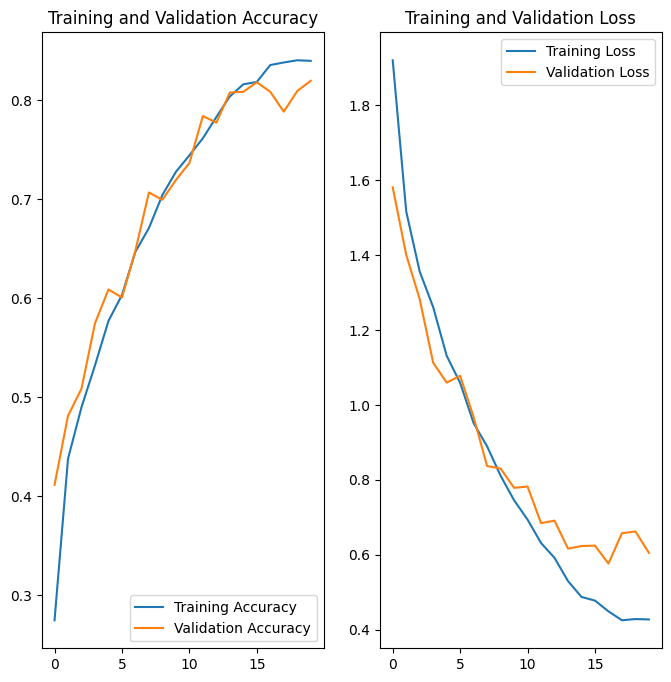

In [ ]:
# Visualizing training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
print("Accuracy of the model on Training Data is: {:.2f}%".format(history.history['accuracy'][-1]*100))
print("Accuracy of the model on Validation Data is: {:.2f}%".format(history.history['val_accuracy'][-1]*100))

Accuracy of the model on Training Data is: 83.98%
Accuracy of the model on Validation Data is: 81.96%


**Observations:**

* The training and validation accuracy of the aforementioned model fall within a similar range, displaying no signs of underfitting or overfitting.
* The model's training accuracy shows a steady increase of upto 83.98%, and validation accuracy also showed the increase till 81.96%.
*   A high training and validation accuracy suggests the model has effectively captured the noise within the data and is well fitted on the validation dataset

## Model Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 889ms/step
Actual Class basal cell carcinoma
Predictive Class squamous cell carcinoma


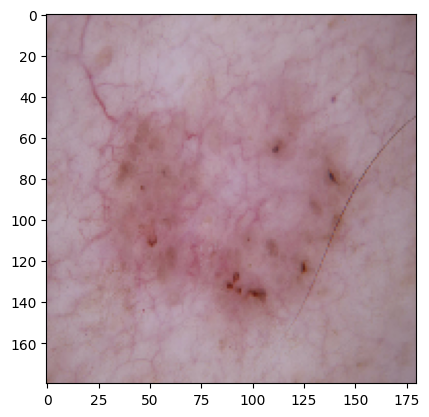

In [ ]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )